# TextMining

**Идея**: подготовить датасет к текстмайнингу и найти самые популярные слова по категориям

In [35]:
import pandas as pd
import re

import string
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import *

Ps = PorterStemmer()

from wordcloud import WordCloud
import warnings

warnings.filterwarnings("ignore")

import plotly.graph_objs as go

In [16]:
# Для первоначального запуска, далее не требуется
# nltk.download('punkt')
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [ ]:
# Hive
host_name = ""
port = 10000
user = ""
password = ""
database = "big_data"

conn = hive.Connection(host=host_name, port=port, username=user, password=password,
                       database=database, auth='CUSTOM')
cur = conn.cursor()

In [2]:
# Импорт с Hadoop
df_query = '''    
SELECT
    DATE(create_date) AS create_date,
    description
FROM 
    big_data.sui_data
WHERE 
    request_type="Messages"
GROUP BY
    DATE(create_date),
    description
HAVING
    COUNT(description)=1
ORDER BY 
    create_date
'''

cur.execute('reset mapreduce.input.fileinputformat.split.maxsize')
cur.execute(df_query)
headers = [x[0] for x in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data, columns=headers)

In [5]:
# Импорт csv
df = pd.read_csv('...\\spam_text_message.csv')

In [67]:
def change_string(x):
    x = [i for i in x if i not in stopwords.words('english')]
    x = [Ps.stem(i) for i in x]
    return x


str_del = '1234567890!#$%&\'()*+,-./:;<=>?@\\^_`{|}~'
gr_df = df.groupby(['Category']).agg({'Message':
                                          lambda x: re.sub(f"[{str_del}]", "", ' '.join(list(x)))})
gr_df.Message = gr_df.Message.apply(
    lambda x: FreqDist(change_string(word_tokenize(x.lower()))))

Wall time: 38.3 s


### Поиск самых популярных по категориям

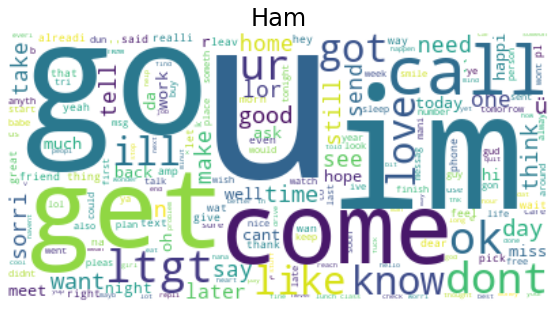

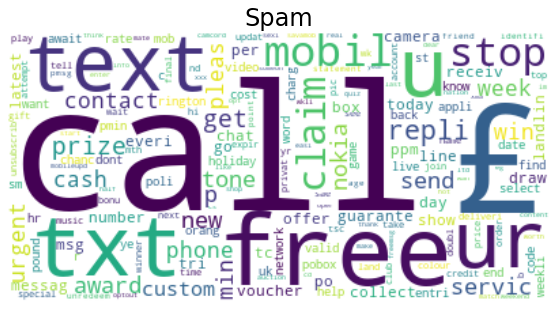

In [68]:
for kateg in gr_df.index:
    plt.figure(figsize=(10, 5))
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(
        dict(gr_df.loc[kateg, 'Message'].most_common()))
    plt.title(f"{kateg.title()}", fontsize=24)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### Формирование гистограмм

In [69]:
top = 5
fig = go.Figure()

for kateg in gr_df.index:
    fig.add_trace(go.Bar(
        name=f'{kateg.title()}',
        x=[i[0] for i in gr_df.loc[kateg, 'Message'].most_common()][:top],
        y=[i[1] for i in gr_df.loc[kateg, 'Message'].most_common()][:top]))

fig.update_layout(
    width=1000, height=600,
    title=dict(text='<b>Частота появления слов<b>', font=dict(size=25)),
    xaxis=dict(tickfont=dict(size=14)),
    yaxis=dict(tickfont=dict(size=14)),
    legend=dict(font=dict(size=20)),
    showlegend=True)

fig.show()